In [ ]:
import findspark
findspark.init()

In [2]:
# %pip install seaborn==0.12.0

In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pandas import DataFrame 
import pandas as pd
from datetime import datetime
from dateutil.relativedelta import relativedelta
from pyspark.sql.window import Window
import seaborn as sns


spark = SparkSession.builder. \
    appName("pyspark nbd"). \
    getOrCreate()

### Run all functions

/usr/local/lib/python3.7/dist-packages/seaborn/axisgrid.py:118: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  self._figure.tight_layout(*args, **kwargs)


True

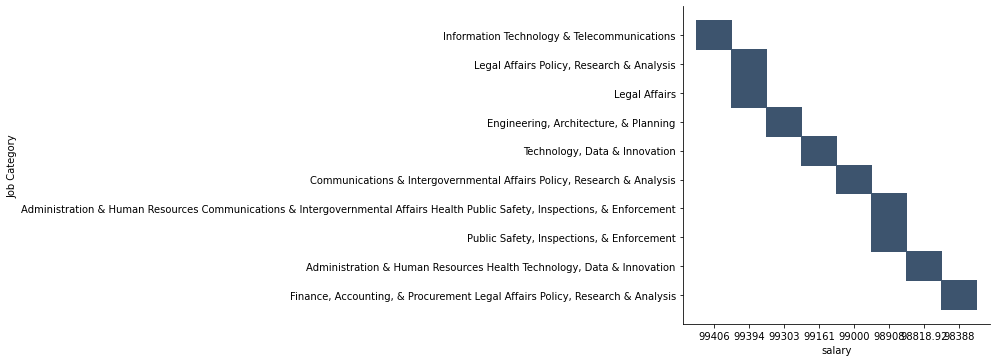

In [44]:
df = spark.read.csv("/dataset/nyc-jobs.csv", header=True)
# df.printSchema()
# df.show()
#Data Analysis
# spark.createDataFrame(get_details_analysis(df)).show(30)

# # number of jobs posting per category 
# positionCategory:DataFrame=get_number_jobs_category(df)
# positionCategory.show(truncate=False)

# highest paid skills
# highestPaidSkill = highest_paid_skill(df)
# highestPaidSkill.show()

# test(df)

# job posting having the highest salary per agency
# higestAgencySalary:DataFrame = highest_salary_per_agency(df)
# higestAgencySalary.show()

# # job positings average salary per agency for the last 2 years
# avgAgencySalary:DataFrame = avg_salary_per_agency(df)
# avgAgencySalary.show() 

# # correlation between the higher degree and the salary
# print("correlation ----> ",find_correlation(df))

# # salary distribution per job category
salary_dist_job_category(df)


### Data Analysis 

In [22]:
df = spark.read.csv("/dataset/nyc-jobs.csv", header=True)
spark.createDataFrame(get_details_analysis(df)).show()

+--------------------+-----------+------------+---------------+--------------------+----------------------+
|              column|[Data type]|[Data Count]|[Distinct_Data]|[Missing Data Count]|[Missing Data In (%) ]|
+--------------------+-----------+------------+---------------+--------------------+----------------------+
|              Job ID|     string|        2946|           1661|                   0|                  0.0%|
|              Agency|     string|        2946|             52|                   0|                  0.0%|
|        Posting Type|     string|        2946|              2|                   0|                  0.0%|
|      # Of Positions|     string|        2946|             34|                   0|                  0.0%|
|      Business Title|     string|        2946|           1244|                   0|                  0.0%|
| Civil Service Title|     string|        2946|            312|                   0|                  0.0%|
|       Title Code No|     s

In [19]:
def get_details_analysis(df):
    
    # Find data types of each column
    lst = df.dtypes
    cols = ['column', '[Data type]']
    df_dtypes = pd.DataFrame(data=lst,columns=cols)

    # Find count for Non empty values
    df_count = df.select([count(col(c)).alias(c) 
                                        for c in df.columns]
                                  ).toPandas().T.reset_index().rename(columns={0: '[Data Count]'
                                                                               ,'index':'column'})

    # Find count distnct values of each column
    df_count_distinct = df.select([countDistinct(col(c)).alias(c) 
                                        for c in df.columns]
                                                  ).toPandas().T.reset_index().rename(columns={0: '[Distinct_Data]'
                                                                                           ,'index':'column'})

    # Find count for empty, None, Null, Nan values
    df_missing_count = df.select([count(when(col(c).contains('None') | col(c).contains('NULL') | (col(c) == '' ) | col(c).isNull() | isnan(c), c)).alias(c) 
                 for c in df.columns]).toPandas().T.reset_index().rename(columns={0: '[Missing Data Count]'
                                                                                          ,'index':'column'})
   
    # Merging dfs to form one combined df to see the detailed overview of each datafield
    df_final = df_dtypes.merge(df_count, on=['column']).merge(df_count_distinct, on=['column']).merge(df_missing_count, on=['column'])

    # Find percentage of missing values
    df_final['[Missing Data In (%) ]'] =  ((df_missing_count['[Missing Data Count]']  / df.count())*100).round(0).astype(str) + '%'

    return df_final


### Whats the number of jobs posting per category (Top 10)?

+--------------------+-------------+
|        Job Category|No of Posting|
+--------------------+-------------+
|Engineering, Arch...|          504|
|Technology, Data ...|          313|
|       Legal Affairs|          226|
|Public Safety, In...|          182|
|Building Operatio...|          181|
|Finance, Accounti...|          169|
|Administration & ...|          134|
|Constituent Servi...|          129|
|              Health|          125|
|Policy, Research ...|          124|
+--------------------+-------------+



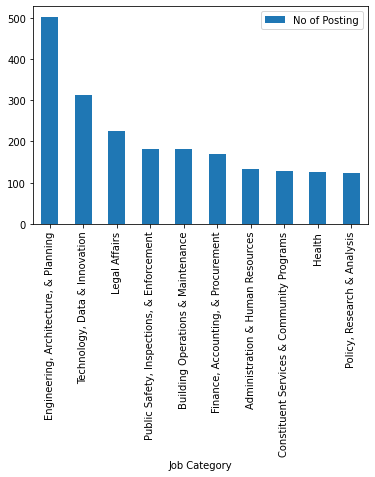

In [45]:
df = spark.read.csv("/dataset/nyc-jobs.csv", header=True)
catRes = get_number_jobs_category(df)
catRes.show()#(truncate=False)
#Displaying Bar chart for the result data
plotBar = catRes.toPandas()
plotBar.plot.bar(x="Job Category",y="No of Posting")


In [4]:
def get_number_jobs_category(df:DataFrame)->DataFrame:
    filterDf = df.select("Job Category").na.drop()#.groupBy("Job Category").count()
    res = filterDf.groupBy("Job Category").count().select(col("Job Category"),col("count").alias("No of Posting"))
    topTenRes = res.orderBy(col("No of Posting").desc()).limit(10)
    return topTenRes

In [5]:
# Mock Test cases for number of jobs posting per category
mock_data = [('Health', '358.0'), ('Public Safety, Inspections, & Enforcement', '1407.0'), ('Maintenance & Operations', '212.0'), ('Policy, Research & Analysis', '312.0')]
expected_result = [('Health', '358.0'), ('Public Safety, Inspections, & Enforcement', '1407.0'), ('Maintenance & Operations', '212.0'), ('Policy, Research & Analysis', '312.0')]
test_get_number_jobs_category(mock_data,expected_result)


In [4]:
# Test case method for top number of jobs posting per category
def test_get_number_jobs_category(mock_data: list, 
                              expected_result: list,
                              schema: list = ['Job Category','# Of Positions']):  
    mock_df = spark.createDataFrame(data = mock_data, schema = schema)
    expected_df = spark.createDataFrame(data = expected_result, schema = schema)
    expecged_res = expected_df.groupBy("Job Category").count()
    assert get_number_jobs_category(mock_df).subtract(expecged_res).count() == 0
    

### What are the highest paid skills in the US market?

In [50]:
df = spark.read.csv("/dataset/nyc-jobs.csv", header=True)
highestPaidSk = highest_paid_skill(df)
highestPaidSk.show()#(truncate=False)

+--------------------+----------+
|    Preferred Skills|Max Salary|
+--------------------+----------+
|The Deputy Commis...|  218587.0|
|       ERROR: #NAME?|  217201.0|
| all candidates m...|  209585.0|
|Extensive experie...|  198518.0|
|â€¢	10+ years of ...|  191913.0|
|Required Skills: ...|  182500.0|
| including the 18...|  180000.0|
| at least 18 mont...|  177374.5|
| ""2"" or ""3"" a...|  169011.0|
|â€¢ Clearly demon...|  167500.0|
|â€¢ Expert knowle...|  167500.0|
|  and City employees|  165000.0|
|â€¢	A Baccalaurea...|  162500.0|
|          commercial|  162051.0|
| and one year of ...|  160099.0|
|â€¢	Basic compute...|  158038.4|
|Candidate must ha...|  151795.0|
|â€¢	Knowledge of ...|  150371.0|
| ""b"" and ""c"" ...|  147500.0|
|â€¢	Supervisory e...|  141743.0|
+--------------------+----------+



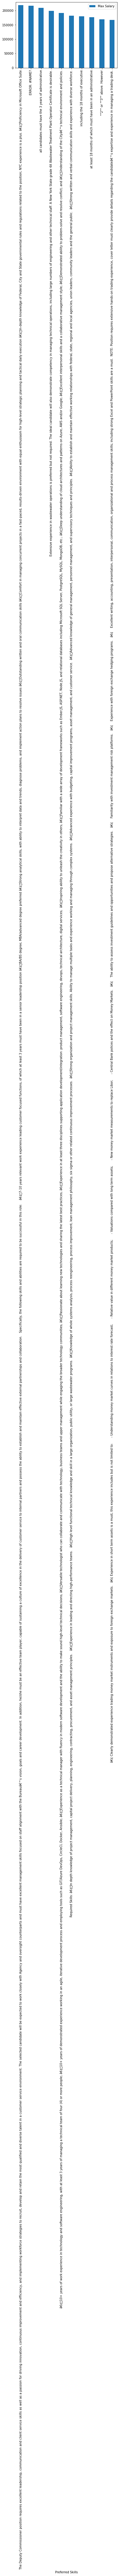

In [51]:
#Displaying Bar chart for the result data
df = spark.read.csv("/dataset/nyc-jobs.csv", header=True)
highestPaidSk = highest_paid_skill(df)
plotBar = highestPaidSk.limit(10).toPandas()
plotBar.plot.bar(x="Preferred Skills",y="Max Salary")

In [46]:
def highest_paid_skill(df:DataFrame)-> DataFrame:
    annualSalDf = getAnnualSalaryColumn(df).select("Preferred Skills","Salary").na.drop()
    skillRes = annualSalDf.groupBy("Preferred Skills").agg(max(col("Salary")).alias("Max Salary"))
    higestPaid = skillRes.orderBy(col("Max Salary").desc()).limit(20)
    return higestPaid
    

In [100]:
# Mock Test cases for highest paid skills in the US market
mock_data = [('journalism','Annual','80000', '96000'), ('accredited by regional','Annual','85000', '97873'), ('individuals must have','Annual','90000', '99406'), ('including the 18 months of executive','Annual','95000', '99394')]
expected_result =  [('journalism','Annual','80000', '96000'), ('accredited by regional','Annual','85000', '97873'), ('individuals must have','Annual','90000', '99406'), ('including the 18 months of executive','Annual','95000', '99394')]
test_highest_paid_skill(mock_data,expected_result)


In [99]:
# Test case method for highest paid skills in the US market
def test_highest_paid_skill(mock_data: list, 
                              expected_result: list,
                              schema: list = ['Preferred Skills', 'Salary Frequency','Salary Range From', 'Salary Range To']):
    mock_df = spark.createDataFrame(data = mock_data, schema = schema)
    df = spark.createDataFrame(data = expected_result, schema = schema)
    expected_df = getAnnualSalaryColumn(df).select("Preferred Skills","Salary")
    assert highest_paid_skill(mock_df).subtract(expected_df).count() == 0
    

 ### Whats the job posting having the highest salary per agency?

In [12]:
df = spark.read.csv("/dataset/nyc-jobs.csv", header=True)
highest_salary_per_agency(df).show(truncate=False)


+------------+------------------------------+---------+
|Posting Type|Agency                        |Salary   |
+------------+------------------------------+---------+
|External    |DEPT OF ENVIRONMENT PROTECTION|218587.0 |
|Internal    |DEPT OF ENVIRONMENT PROTECTION|218587.0 |
|Internal    |POLICE DEPARTMENT             |217201.0 |
|External    |POLICE DEPARTMENT             |217201.0 |
|External    |DISTRICT ATTORNEY KINGS COUNTY|191913.0 |
|Internal    |DISTRICT ATTORNEY KINGS COUNTY|191913.0 |
|External    |NYC HOUSING AUTHORITY         |180000.0 |
|Internal    |NYC HOUSING AUTHORITY         |180000.0 |
|External    |NYC EMPLOYEES RETIREMENT SYS  |177374.5 |
|Internal    |NYC EMPLOYEES RETIREMENT SYS  |177374.5 |
|Internal    |DEPT OF HEALTH/MENTAL HYGIENE |170133.84|
|External    |DEPT OF HEALTH/MENTAL HYGIENE |170133.84|
|External    |OFFICE OF THE COMPTROLLER     |167500.0 |
|Internal    |OFFICE OF THE COMPTROLLER     |167500.0 |
|Internal    |OFFICE OF THE COMPTROLLER     |167

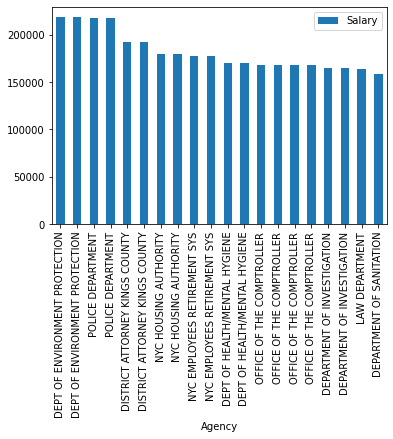

In [54]:
#Displaying Bar chart for the result data
df = spark.read.csv("/dataset/nyc-jobs.csv", header=True)
plotBar=highest_salary_per_agency(df).limit(20).toPandas()
plotBar.plot.bar(x="Agency",y="Salary")

In [53]:
def highest_salary_per_agency(df:DataFrame)->DataFrame:
    agencyRes = getAnnualSalaryColumn(df).select("Posting Type","Agency","Salary")
    windowAgency = Window.partitionBy("Posting Type","Agency").orderBy(col("Salary").desc())
    higestAgencyRes = agencyRes.withColumn("denceRank",dense_rank().over(windowAgency)).filter(col("denceRank") == 1).drop("denceRank")
    higestAgencyRes = higestAgencyRes.orderBy(col("Salary").desc())
    return higestAgencyRes


In [60]:
# Mock Test cases for job posting having the highest salary per agency
mock_data = [('Internal','LAW DEPARTMENT','Annual','80000', '96000'), ('Internal','POLICE DEPARTMENT','Annual','85000', '97873'), ('External','LAW DEPARTMENT','Annual','90000', '97000'), ('External','POLICE DEPARTMENT','Annual','95000', '99873')]
expected_result = [('Internal','LAW DEPARTMENT','Annual','80000', '96000'), ('Internal','POLICE DEPARTMENT','Annual','85000', '97873'), ('External','LAW DEPARTMENT','Annual','90000', '97000'), ('External','POLICE DEPARTMENT','Annual','95000', '99873')]
test_highest_salary_per_agency(mock_data,expected_result)


In [59]:
# Test case method for job posting having the highest salary per agency
def test_highest_salary_per_agency(mock_data: list, 
                              expected_result: list,
                              schema: list = ['Posting Type','Agency','Salary Frequency','Salary Range From', 'Salary Range To']):  
    mock_df = spark.createDataFrame(data = mock_data, schema = schema)
    df = spark.createDataFrame(data = expected_result, schema = schema)
    expected_df = getAnnualSalaryColumn(df).select("Posting Type","Agency","Salary")
    assert highest_salary_per_agency(mock_df).subtract(expected_df).count() == 0
    

### Whats the job positings average salary per agency for the last 2 years? 

In [75]:
df = spark.read.csv("/dataset/nyc-jobs.csv", header=True)
avg_salary_per_agency(df).show(truncate=False)


+------------+------------------------------+------------------+
|Posting Type|Agency                        |Avg Salary        |
+------------+------------------------------+------------------+
|Internal    |DEPARTMENT OF CORRECTION      |139105.1          |
|External    |DEPT OF ENVIRONMENT PROTECTION|109340.11111111111|
|External    |DEPARTMENT OF SANITATION      |128247.5          |
|Internal    |HRA/DEPT OF SOCIAL SERVICES   |104911.0          |
|External    |DEPARTMENT OF CORRECTION      |139105.1          |
|Internal    |DEPARTMENT OF SANITATION      |128247.5          |
|Internal    |DEPT OF ENVIRONMENT PROTECTION|103096.45454545454|
+------------+------------------------------+------------------+



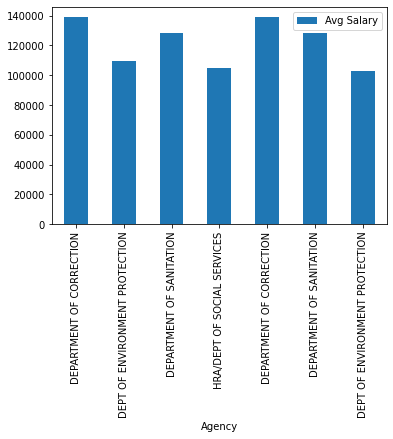

In [56]:
#Displaying Bar chart for the result data
df = spark.read.csv("/dataset/nyc-jobs.csv", header=True)
avgSalBar=avg_salary_per_agency(df).limit(20).toPandas()
avgSalBar.plot.bar(x="Agency",y="Avg Salary")


In [55]:
def avg_salary_per_agency(df:DataFrame)->DataFrame:
    lastYearDate=(datetime.now() + relativedelta(years=-2)).strftime("%Y-%m-%d")+"T00:00:00"
    agencyRes = getAnnualSalaryColumn(df).filter(col("`Posting Date`") >= lastYearDate).na.drop()
    avgAgencyRes = agencyRes.groupBy("Posting Type","Agency").agg(avg(col("Salary")).alias("Avg Salary"))
    return avgAgencyRes

In [74]:
# Mock Test cases for job positings average salary per agency for the last 2 years?
mock_data = [('Internal','LAW DEPARTMENT','Annual','80000', '96000','2023-04-01T00:00:00'), ('Internal','POLICE DEPARTMENT','Annual','85000', '97873','2022-04-01T00:00:00'), ('External','LAW DEPARTMENT','Annual','90000', '97000','2023-04-05T00:00:00'), ('External','POLICE DEPARTMENT','Annual','95000', '99873','2022-04-31T00:00:00')]
expected_result = [('Internal','LAW DEPARTMENT','Annual','80000', '96000','2023-04-01T00:00:00'), ('Internal','POLICE DEPARTMENT','Annual','85000', '97873','2022-04-01T00:00:00'), ('External','LAW DEPARTMENT','Annual','90000', '97000','2023-04-05T00:00:00'), ('External','POLICE DEPARTMENT','Annual','95000', '99873','2022-04-31T00:00:00')]
test_avg_salary_per_agency(mock_data,expected_result)



In [73]:
# Test case method for job positings average salary per agency for the last 2 years?
def test_avg_salary_per_agency(mock_data: list, 
                              expected_result: list,
                              schema: list = ['Posting Type','Agency','Salary Frequency','Salary Range From', 'Salary Range To','Posting Date']):  
    mock_df = spark.createDataFrame(data = mock_data, schema = schema)
    df = spark.createDataFrame(data = expected_result, schema = schema)
    expected_df = getAnnualSalaryColumn(df).select("Posting Type","Agency","Salary")
    assert avg_salary_per_agency(mock_df).subtract(expected_df).count() == 0


### Is there any correlation between the higher degree and the salary?

In [10]:
# The correlation is very close to 0, which tells there is very little correlation between higher degree salary
# Observation : My be is we include the experience as well, it might produce better correlation
df = spark.read.csv("/dataset/nyc-jobs.csv", header=True)
print("correlation ----> ",find_correlation(df))

correlation ---->  -0.19542825529320362


In [9]:
def find_correlation(df:DataFrame)->float:

    annualSalDf = getAnnualSalaryColumn(df)
    filterdDf = annualSalDf[['Minimum Qual Requirements', 'Salary']].dropna()
    filterdDf = filterdDf.withColumn("HighestDegree", when(filterdDf['Minimum Qual Requirements'].contains('Ph.D'),  1)
                                       .when(filterdDf['Minimum Qual Requirements'].contains('master') | filterdDf['Minimum Qual Requirements'].contains('Master') , 2)
                                       .when(filterdDf['Minimum Qual Requirements'].contains('baccalaureate') | filterdDf['Minimum Qual Requirements'].contains('bachelor') , 3)
                                       .otherwise(4).cast('int'))

    corrRes = filterdDf.stat.corr("HighestDegree","Salary")
    
    return corrRes


In [56]:
# Mock Test cases for correlation between the higher degree and the salary
mock_data = [('bachelor','Annual','80000', '85000'), ('master','Annual','9', '10'), ('bachelor','Annual','100', '120'), ('Ph.D','Annual','85000', '90000')]
expected_result = 1
test_find_correlation(mock_data,expected_result)


In [8]:
# Test case method for correlation between the higher degree and the salary
def test_find_correlation(mock_data: list, 
                              expected_result: list,
                              schema: list = ['Minimum Qual Requirements','Salary Frequency','Salary Range From', 'Salary Range To']):  
    mock_df = spark.createDataFrame(data = mock_data, schema = schema)
    assert find_correlation(mock_df) < expected_result


### Whats the salary distribution per job category?

In [66]:
def salary_dist_job_category(df:DataFrame):
    df=df.select('Salary Range To','Job Category').filter(col('Job Category').isNotNull())
    jobCatDf = df.groupBy('Job Category').agg(max('Salary Range To').alias("salary")).orderBy(col("salary").desc())
    resDf = jobCatDf.limit(10).toPandas()
    sns.displot(data=resDf,x="salary",y="Job Category")
    return True

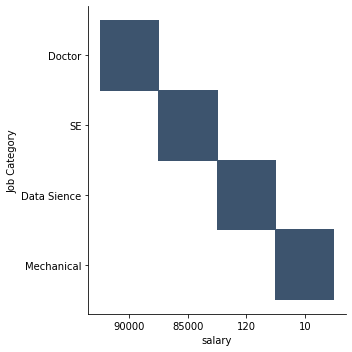

In [67]:
# Mock Test cases for salary distribution per job category
mock_data = [('SE','Annual','80000', '85000'), ('Mechanical','Hourly','9', '10'), ('Data Sience','Daily','100', '120'), ('Doctor','Annual','85000', '90000')]
test_salary_dist_job_category(mock_data)

In [62]:
# Test case method for salary distribution per job category
def test_salary_dist_job_category(mock_data: list, 
                              schema: list = ['Job Category','Salary Frequency','Salary Range From', 'Salary Range To']):  
    mock_df = spark.createDataFrame(data = mock_data, schema = schema)
    assert salary_dist_job_category(mock_df)


In [48]:
# Merging 2 salary column to 1 common method 
# working days in US in a year: 260 got from : Google Analysis
# working hours in US in a day: 8 hours got from : Google Analysis

def getAnnualSalaryColumn(df)->DataFrame : 
    #converting salary on hourly scale to annual scale and daily scale to annual scale
    salaryDf = df.withColumn("Salary", when(df['Salary Frequency'] == "Hourly", round((df['Salary Range From'] + df['Salary Range To'])*260*8.0/2,2))
                                   .when(df['Salary Frequency'] == "Daily", round((df['Salary Range From'] + df['Salary Range To'])*260/2,2))
                                   .otherwise(round((df['Salary Range From'] + df['Salary Range To'])/2,2)))
    return salaryDf
